In [95]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [96]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [97]:
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1 ), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> N, 32 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=7) # -> N, 64, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [98]:
cnn_model = AutoEncoder_CNN().to(device)

In [99]:
train_data = MNIST(root='./',
                   train=True,
                   transform=transforms.ToTensor(),
                   target_transform=None,
                   download=True)


train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              shuffle=True)

In [100]:
sample_data = train_data[0][0].to(device)
sample_data.shape

torch.Size([1, 28, 28])

In [101]:
outputs = cnn_model(sample_data)
encoded_output = outputs[0]
decoded_output = outputs[1]

In [102]:
encoded_output.shape, decoded_output.shape

(torch.Size([128, 1, 1]), torch.Size([1, 28, 28]))

In [103]:
# Initalize the loss and optimizer for training model

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(cnn_model.parameters(),
                             lr=0.001)

schedular = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)

In [104]:
# Train our model
num_epochs = 10

for epoch in range(num_epochs):
    cnn_model.train()

    print(f'Epcoh:{epoch+1} | Learning Rate: {optimizer.param_groups[0]['lr']}')

    for index, (image, label)in enumerate(train_dataloader):
        image = image.to(device)
        
        output = cnn_model(image)

        loss = criterion(output[1], image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    schedular.step()

    print(f'Loss: {loss}\n--------')

Epcoh:1 | Learning Rate: 0.001
Loss: 0.005227250512689352
--------
Epcoh:2 | Learning Rate: 0.001
Loss: 0.003949408419430256
--------
Epcoh:3 | Learning Rate: 0.001
Loss: 0.0024409019388258457
--------
Epcoh:4 | Learning Rate: 0.001
Loss: 0.0020434523466974497
--------
Epcoh:5 | Learning Rate: 0.001
Loss: 0.0019761803559958935
--------
Epcoh:6 | Learning Rate: 0.001
Loss: 0.0015974424313753843
--------
Epcoh:7 | Learning Rate: 0.001
Loss: 0.001363476156257093
--------
Epcoh:8 | Learning Rate: 0.001
Loss: 0.001118241809308529
--------
Epcoh:9 | Learning Rate: 0.001
Loss: 0.0012377183884382248
--------
Epcoh:10 | Learning Rate: 0.001
Loss: 0.001217851648107171
--------


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

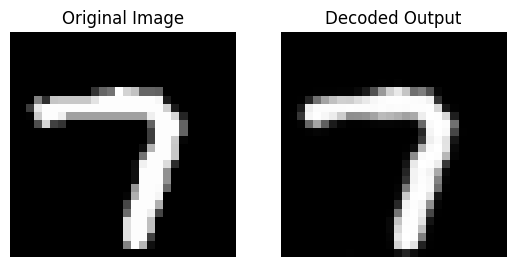

In [105]:
# Visualize the original data/image, encoded output and the decodeded output of the trained model
import random

# picks a random image from our test data
rand_int = random.choice(range(len(train_data)))
image = train_data[rand_int][0]


# pass the data into the model
model_output = cnn_model(image.to(device))

# get the decode output data and plot it in graph/image 
model_decoded_output = model_output[1].detach().cpu()

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0), cmap='grey')
plt.title('Original Image')
plt.axis(False)

# plot the decoded image
plt.subplot(1, 2, 2)
plt.imshow(model_decoded_output.permute(1, 2, 0), cmap='grey')
plt.title('Decoded Output')
plt.axis(False)





# # get the encoded output data and reshape it to plot in graph/image
# model_encoded_output = model_output[0].detach().cpu()
# encoded_output_reshaped = model_encoded_output.reshape(1, -1, 1)


# # plot the encoded latent representation
# plt.figure(figsize=(3, 3))
# plt.imshow(model_encoded_output.permute(1, 2, 0), cmap='grey')
# plt.title('Encoded Data Output')
# print(encoded_output_reshaped.shape)

In [106]:
from Modules.output import eval_model

# Get all the encoded output form the model and their respective true labels 

encoded_data, label_data = eval_model(model=cnn_model,
                                      dataloader=train_dataloader,
                                      device=device)

encoded_data = encoded_data.reshape(encoded_data.shape[0], -1)

In [107]:
encoded_data.shape, label_data.shape

(torch.Size([60000, 128]), torch.Size([60000]))

# KMEANS Clustering Algorithm 

In [108]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
cluster_output = kmeans.fit_predict(encoded_data.cpu())
cluster_output = torch.tensor(cluster_output)

In [109]:
# AMI score to access the quality of the cluster
from sklearn.metrics import adjusted_mutual_info_score

ami_score = adjusted_mutual_info_score(label_data, cluster_output)
print(ami_score)

0.48535466698024277


In [110]:
from torchmetrics import ConfusionMatrix

confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=10)
confusion_matrix_tensor = confusion_matrix(cluster_output, label_data)

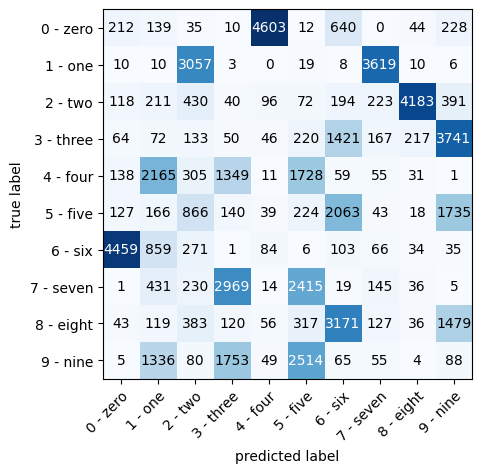

In [111]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix_tensor.numpy(),
    class_names=train_data.classes
    )

In [112]:
# Apply the PCA for the dimensionality reduction of the encoded data and convert it into a 2d vector for better visualization in a 2d-graph
# Apply PCA to the encoded data for better visualization in 2d graph

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_data = pca.fit_transform(encoded_data.cpu())

c:\Users\ASUS\Desktop\ML Projects\Projects(ML)\.venv\Lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


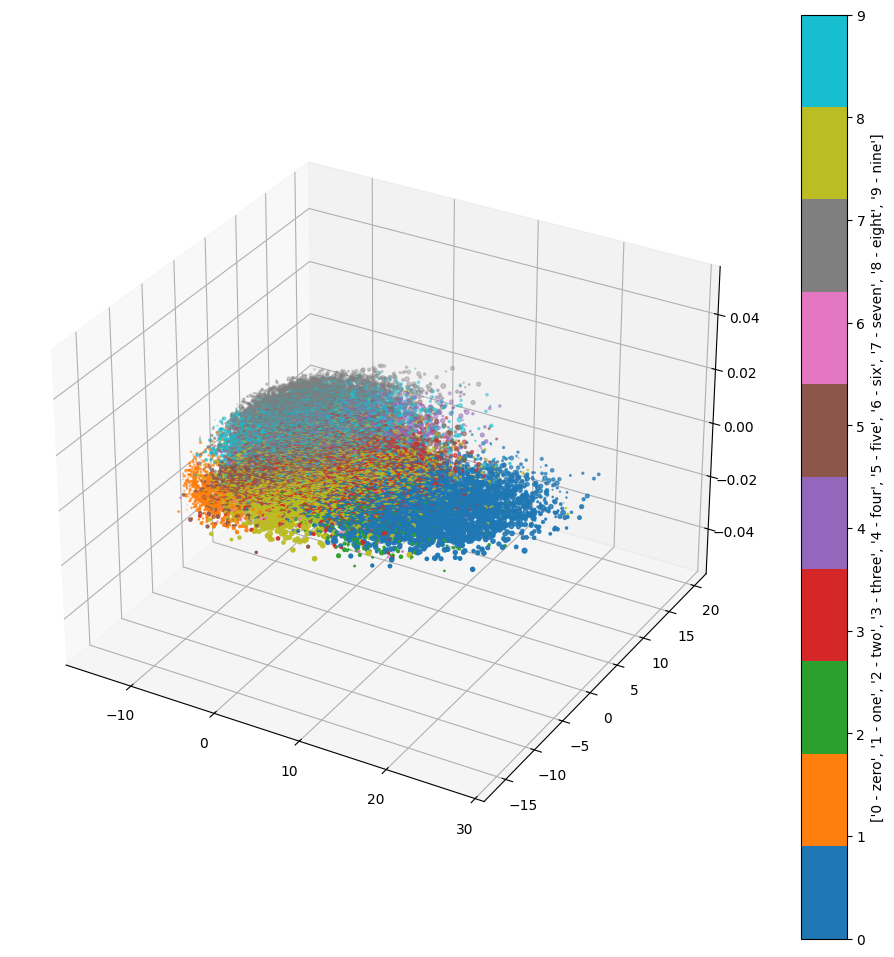

In [113]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': '3d'})
ax = plt.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=label_data, cmap='tab10')

cbar = plt.colorbar(ax)
cbar.set_label(train_data.classes)

In [114]:
from sklearn.cluster import KMeans
# we have 10 digits in the dataset
n_clusters = 10

# Apply kmeans using sklearn
kmeans = KMeans(n_clusters=n_clusters)

# Get training predictions
y_kmeans = kmeans.fit_predict(encoded_data.cpu())


In [115]:
y_kmeans, label_data

(array([1, 5, 7, ..., 7, 6, 5], shape=(60000,), dtype=int32),
 tensor([1, 5, 2,  ..., 2, 3, 5]))

In [116]:
from sklearn.metrics import adjusted_mutual_info_score

ami_score = adjusted_mutual_info_score(labels_true=label_data.numpy(), labels_pred=y_kmeans)

In [117]:
ami_score*100

np.float64(51.478179291067164)

In [118]:
from Modules.conf_mat_acc import conf_mat_acc

acc = conf_mat_acc(confusion_matrix_tensor=confusion_matrix_tensor,
                   num_labels=len(train_data.classes),
                   len_data=len(train_data))



In [119]:
acc

2.181666612625122

In [120]:
# AMI evaluates the quality of the cluster and not directly how well the model is predicting the true labels of the data.

## Watch a video on AMI to learn more about it and also confirm if the above statement is correct